# Import libraries

In [271]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, get_cosine_schedule_with_warmup
from datasets import load_dataset
import pathlib
import torch
import pandas
from collections import Counter

# Load the data

We'll use the Million Song Dataset from Kaggle as our training data. We can use the Datasets class from Huggingface to conveniently load the data and utilize visualization tools to easily select a subset of it.

Using custom data configuration default-a497b4a7fe246336
Found cached dataset csv (/Users/renaef/.cache/huggingface/datasets/csv/default-a497b4a7fe246336/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

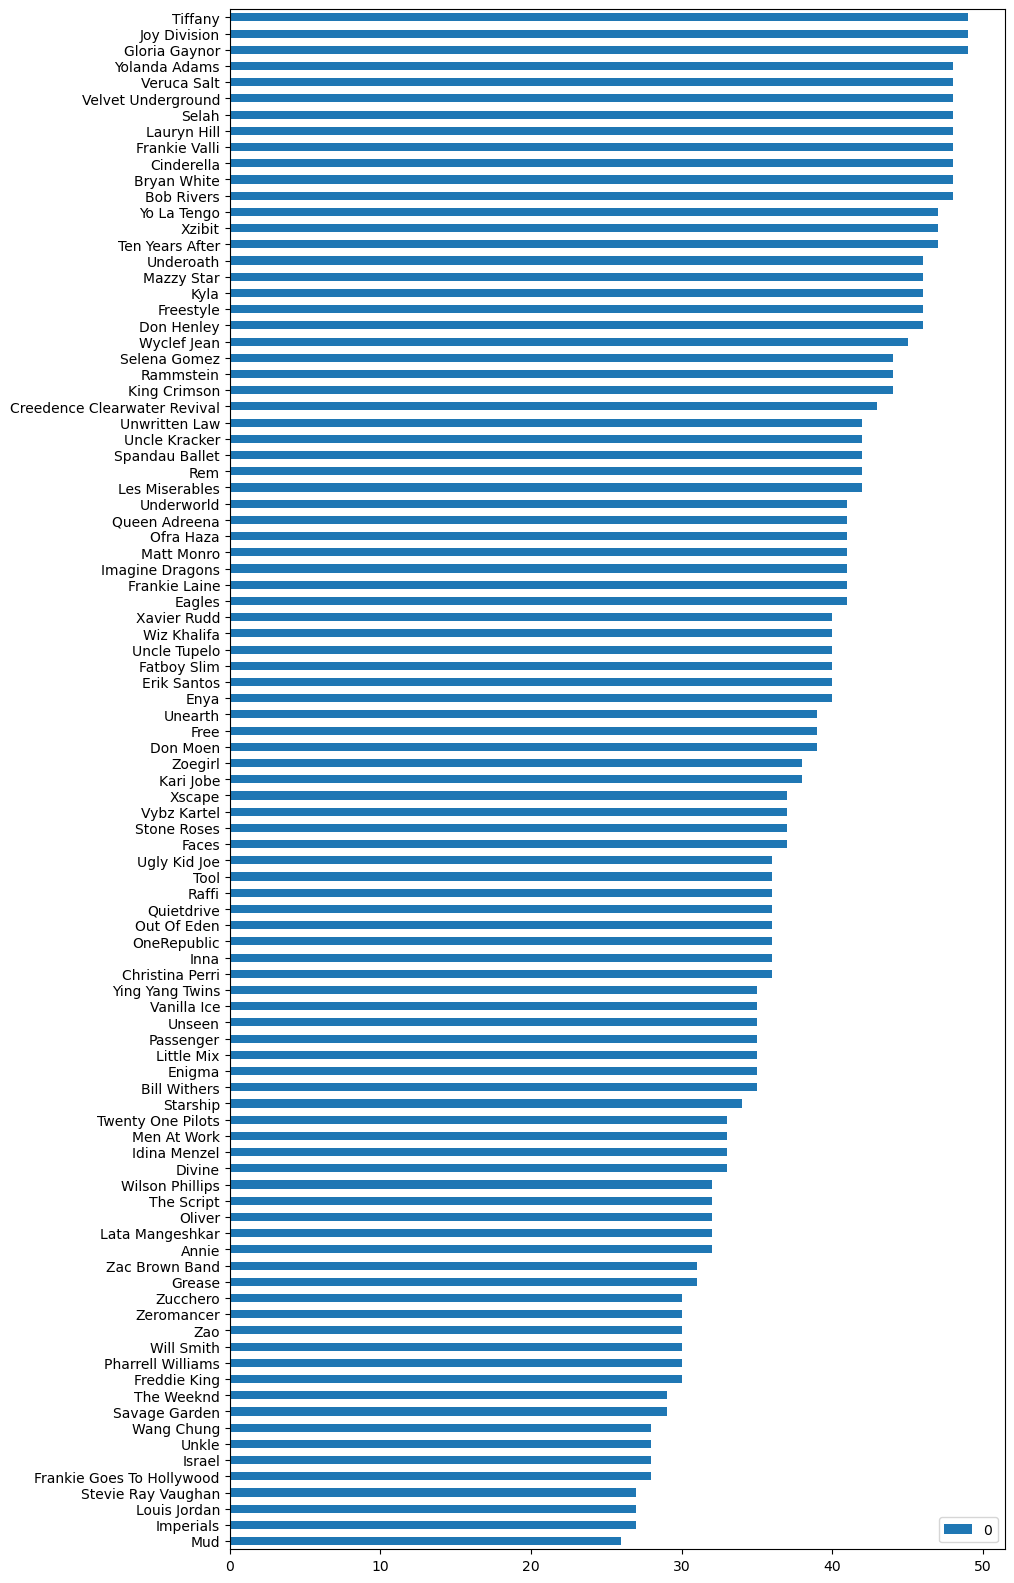

In [272]:
# Load the data and discard the dictionary wrapper.
dataset = load_dataset("csv", data_files="./data/spotify_millsongdata.csv")['train']

# Count how many times each artist appears in the data.
artist_counts = Counter(dataset['artist'])

# Choose artists with fewer than 50 and more than 25 songs.
filtered_artists = dict(filter(lambda elem: elem[1] < 50 and elem[1] > 25, artist_counts.items()))

# Create a list of artists sorted by the number of songs they have in the data.
sorted_artists = dict(sorted(filtered_artists.items(), key=lambda item: item[1]))

# Plot the sorted list of artists.
df = pandas.DataFrame.from_dict(sorted_artists, orient='index')
df.plot(kind='barh',figsize=(10, 20))

In [273]:
# Choose one artist from this subset because it will be faster to fine-tune the model on fewer data (for this example).
filtered_dataset = dataset.filter(lambda example: 'eagles' in example["artist"].lower())

# Remove uneeded columns and retain only the text column that holds the song lyrics.
filtered_dataset = filtered_dataset.remove_columns(["artist","song","link"])

# Split the data into test and training datasets (0.20 of the shuffled dataset will be reserved to test the model).
dataset_dict = filtered_dataset.train_test_split(test_size=0.20, shuffle=True, seed=123)

print(dataset_dict)

  0%|          | 0/58 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 32
    })
    test: Dataset({
        features: ['text'],
        num_rows: 9
    })
})


# Process the data

In [274]:
# Create the GPT-2 text tokenizer. This will convert text into a numerical representation for the training process.
tokenizer = AutoTokenizer.from_pretrained('gpt2')

# Define a function that we'll use in the map function to tokenze data in the 'text' column.
def tokenize_function(examples):
    return tokenizer(examples["text"])

# Apply tokenizer on each song text in the dataset & remove the raw text column.
# It creates a dictionary with keys input_id and attention_mask, and each key references an array of arrays.
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True, remove_columns=["text"])

# Get the maximum length, in number of tokens, for the inputs to the GPT-2 model.
block_size = tokenizer.model_max_length

# Define a function that we'll use in a map function to format the data for the GPT-2 model.
def group_texts(examples):

    # Concatenate all tokenized texts and masks.
    # For each key in the dictionary, use sum(examples[key], []) to concatenate all lists.
    concatenated_examples = {key: sum(examples[key], []) for key in examples.keys()}

    # Get the total length of the concatenated texts.
    total_length = len(concatenated_examples["input_ids"])

    # Calculate the max length by rounding down the total length to the nearest block size. 
    max_length = (total_length // block_size) * block_size

    # Create a dictionary of keys with values split into chunks of max length.
    result_dict = {
        # From i to range of max_length, by block_size, create a list of values from i to i + block_size.
        keys: [values[i : i + block_size] for i in range(0, max_length, block_size)] 

        # Perform this for every key in the dictionary.
        for keys, values in concatenated_examples.items()
    }

    # Create labels from copies of the input_ids. This is necessary for language modeling. Since these are shifted inside the model, we can set input_ids = labels.
    result_dict["labels"] = result_dict["input_ids"].copy()

    return result_dict

# Use the map function and the group_texts function to format the data.
lm_datasets = tokenized_datasets.map(group_texts, batched=True)

print(lm_datasets)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /Users/renaef/.cache/huggingface/hub/models--gpt2/snapshots/f27b190eeac4c2302d24068eabf5e9d6044389ae/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
   

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2
    })
})


# Train the model

In [279]:
output_dir = "output"
seed = 123
LEARNING_RATE = 1.372e-4
num_train_epochs = 16

# Select a pretrained GPT-2 model with a head that we can train
model = AutoModelForCausalLM.from_pretrained('gpt2', cache_dir=pathlib.Path('cache').resolve())

training_args = TrainingArguments(
    output_dir,
    overwrite_output_dir=True,
    evaluation_strategy = "epoch",
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    num_train_epochs=num_train_epochs,
    save_total_limit=10,
    save_strategy='epoch',
    save_steps=1,
    report_to=None,
    seed=seed,
    logging_steps=5,
    do_eval=True,
    eval_steps=1,
    load_best_model_at_end=True
    # disable_tqdm=True
)

trainer = Trainer(
    model=model,
    # tokenizer=tokenizer,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"]
)

train_dataloader = trainer.get_train_dataloader()
num_train_steps = len(train_dataloader)
trainer.create_optimizer_and_scheduler(num_train_steps)
trainer.lr_scheduler = get_cosine_schedule_with_warmup(
    trainer.optimizer,
    num_warmup_steps=0,
    num_training_steps=num_train_steps
)

trainer.train()
evaluation = trainer.evaluate()

loading configuration file config.json from cache at /Users/renaef/Projects/mlapp-demo/cache/models--gpt2/snapshots/f27b190eeac4c2302d24068eabf5e9d6044389ae/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transf

  0%|          | 0/32 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-2
Configuration saved in output/checkpoint-2/config.json


{'eval_loss': 3.304556369781494, 'eval_runtime': 1.8114, 'eval_samples_per_second': 1.104, 'eval_steps_per_second': 0.552, 'epoch': 1.0}


Model weights saved in output/checkpoint-2/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-4
Configuration saved in output/checkpoint-4/config.json


{'eval_loss': 3.1107771396636963, 'eval_runtime': 2.0442, 'eval_samples_per_second': 0.978, 'eval_steps_per_second': 0.489, 'epoch': 2.0}


Model weights saved in output/checkpoint-4/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-8] due to args.save_total_limit


{'loss': 3.7075, 'learning_rate': 6.860000000000001e-05, 'epoch': 2.5}


***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-6
Configuration saved in output/checkpoint-6/config.json


{'eval_loss': 3.1092422008514404, 'eval_runtime': 1.845, 'eval_samples_per_second': 1.084, 'eval_steps_per_second': 0.542, 'epoch': 3.0}


Model weights saved in output/checkpoint-6/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-8
Configuration saved in output/checkpoint-8/config.json


{'eval_loss': 2.904324769973755, 'eval_runtime': 1.8156, 'eval_samples_per_second': 1.102, 'eval_steps_per_second': 0.551, 'epoch': 4.0}


Model weights saved in output/checkpoint-8/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-12] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


{'loss': 3.0538, 'learning_rate': 0.0, 'epoch': 5.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-10
Configuration saved in output/checkpoint-10/config.json


{'eval_loss': 2.7119216918945312, 'eval_runtime': 1.8198, 'eval_samples_per_second': 1.099, 'eval_steps_per_second': 0.55, 'epoch': 5.0}


Model weights saved in output/checkpoint-10/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-12
Configuration saved in output/checkpoint-12/config.json


{'eval_loss': 2.636622667312622, 'eval_runtime': 2.3813, 'eval_samples_per_second': 0.84, 'eval_steps_per_second': 0.42, 'epoch': 6.0}


Model weights saved in output/checkpoint-12/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-16] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-14
Configuration saved in output/checkpoint-14/config.json


{'eval_loss': 2.863708972930908, 'eval_runtime': 1.8317, 'eval_samples_per_second': 1.092, 'eval_steps_per_second': 0.546, 'epoch': 7.0}


Model weights saved in output/checkpoint-14/pytorch_model.bin


{'loss': 2.7227, 'learning_rate': 6.859999999999982e-05, 'epoch': 7.5}


***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-16
Configuration saved in output/checkpoint-16/config.json


{'eval_loss': 2.743126392364502, 'eval_runtime': 1.7916, 'eval_samples_per_second': 1.116, 'eval_steps_per_second': 0.558, 'epoch': 8.0}


Model weights saved in output/checkpoint-16/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-5] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-18
Configuration saved in output/checkpoint-18/config.json


{'eval_loss': 2.537809371948242, 'eval_runtime': 1.8038, 'eval_samples_per_second': 1.109, 'eval_steps_per_second': 0.554, 'epoch': 9.0}


Model weights saved in output/checkpoint-18/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-10] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


{'loss': 2.5249, 'learning_rate': 0.0001372, 'epoch': 10.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-20
Configuration saved in output/checkpoint-20/config.json


{'eval_loss': 2.514470338821411, 'eval_runtime': 1.8052, 'eval_samples_per_second': 1.108, 'eval_steps_per_second': 0.554, 'epoch': 10.0}


Model weights saved in output/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-22
Configuration saved in output/checkpoint-22/config.json


{'eval_loss': 2.4514384269714355, 'eval_runtime': 1.8193, 'eval_samples_per_second': 1.099, 'eval_steps_per_second': 0.55, 'epoch': 11.0}


Model weights saved in output/checkpoint-22/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-15] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-24
Configuration saved in output/checkpoint-24/config.json


{'eval_loss': 2.432738780975342, 'eval_runtime': 1.868, 'eval_samples_per_second': 1.071, 'eval_steps_per_second': 0.535, 'epoch': 12.0}


Model weights saved in output/checkpoint-24/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-20] due to args.save_total_limit


{'loss': 2.2459, 'learning_rate': 6.859999999999999e-05, 'epoch': 12.5}


***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-26
Configuration saved in output/checkpoint-26/config.json


{'eval_loss': 2.403352737426758, 'eval_runtime': 1.816, 'eval_samples_per_second': 1.101, 'eval_steps_per_second': 0.551, 'epoch': 13.0}


Model weights saved in output/checkpoint-26/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-2] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-28
Configuration saved in output/checkpoint-28/config.json


{'eval_loss': 2.4003894329071045, 'eval_runtime': 1.8793, 'eval_samples_per_second': 1.064, 'eval_steps_per_second': 0.532, 'epoch': 14.0}


Model weights saved in output/checkpoint-28/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-6] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


{'loss': 2.0399, 'learning_rate': 0.0, 'epoch': 15.0}


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-30
Configuration saved in output/checkpoint-30/config.json


{'eval_loss': 2.392568588256836, 'eval_runtime': 1.8267, 'eval_samples_per_second': 1.095, 'eval_steps_per_second': 0.547, 'epoch': 15.0}


Model weights saved in output/checkpoint-30/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-14] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


  0%|          | 0/1 [00:00<?, ?it/s]

Saving model checkpoint to output/checkpoint-32
Configuration saved in output/checkpoint-32/config.json


{'eval_loss': 2.3031489849090576, 'eval_runtime': 1.8225, 'eval_samples_per_second': 1.097, 'eval_steps_per_second': 0.549, 'epoch': 16.0}


Model weights saved in output/checkpoint-32/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-4] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output/checkpoint-32 (score: 2.3031489849090576).
***** Running Evaluation *****
  Num examples = 2
  Batch size = 8


{'train_runtime': 1006.4495, 'train_samples_per_second': 0.175, 'train_steps_per_second': 0.032, 'train_loss': 2.667828381061554, 'epoch': 16.0}


  0%|          | 0/1 [00:00<?, ?it/s]

# Test the model

In [284]:
start = "I am"
num_sequences =  5
min_length =  100
max_length =   150
temperature = 0.75
top_p = 0.90
top_k = 75
repetition_penalty =  1

tokenized_prompt = tokenizer(start, return_tensors="pt")

encoded_prompt = tokenized_prompt.input_ids.to(trainer.model.device)
attention_mask = tokenized_prompt.attention_mask.to(trainer.model.device)

# prediction
output_sequences = trainer.model.generate(
    input_ids=encoded_prompt,
    attention_mask=attention_mask,
    max_length=max_length,
    min_length=min_length,
    temperature=float(temperature),
    top_p=float(top_p),
    top_k=int(top_k),
    do_sample=True,
    repetition_penalty=repetition_penalty,
    num_return_sequences=num_sequences)

def post_process(output_sequences):
    generated_sequences = []

    # decode prediction
    for generated_sequence_idx, generated_sequence in enumerate(output_sequences):
        generated_sequence = generated_sequence.tolist()
        text = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True, skip_special_tokens=True)
        generated_sequences.append(text.strip())
                    
    return generated_sequences

post_process(output_sequences)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['I am standing by, as if there is no more to say, but I\'m not the only one."\n\nShe knew the girl was talking, she knew she was talking, and she would never, ever let anyone down.\n\nIt was just a matter of time before she found herself in a new world, and she would never be alone again.\n\nShe was the only one who had ever known a girl like me.\n\nShe was the only one who could call upon a soul who could love and take care of herself, who could even take care of herself.\n\nShe was the only one who could be loved by a woman who could stand by and watch.\n\nShe was the only one who could be',
 'I am still young and lonely."\n\nI don\'t know what else to say to this.\n\n(She turns away and leaves)\n\nI still feel a part of you, even if it\'s a part of you that I never had.\n\n(She leaves)\n\n(She leaves)\n\n(She leaves)\n\n(She leaves)\n\n(She leaves)\n\n(She leaves)\n\n(She leaves)\n\n(She leaves)\n\n(She leaves)\n\n(She leaves)\n\n(She leaves)\n\n(She leaves)\n\n(She leaves)\n\n(She

# Sources

- Chapter 7: Deep Learning for Text, Deep Learning in Python by François Chollet
- GPT-2, Accessed at: https://huggingface.co/gpt2
- OpenAPI GPT-2, Accessed at: https://huggingface.co/docs/transformers/main/en/model_doc/gpt2
- Fine-tune a pretrained model, Accessed at: https://huggingface.co/docs/transformers/training#train-in-native-pytorch
- HuggingArtists - Train a model to generate lyrics, Accessed at: https://colab.research.google.com/github/AlekseyKorshuk/huggingartists/blob/master/huggingartists-demo.ipynb
- HuggingTweets - Train a model to generate tweets, Accessed at: https://colab.research.google.com/github/borisdayma/huggingtweets/blob/master/huggingtweets-demo.ipynb
- Spotify Million Song Dataset, Accessed at: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
- Datasets, Accessed at: https://huggingface.co/docs/datasets/index